In [1]:
import numpy as np
import math

The equation we are testing is

$$
\begin{cases}
|u'(x)|= 1, \qquad\text{for}\; -1<x<1,\\
u(-1) = u(1) = 0.
\end{cases}
$$ 

The exact solution (viscosity solution) is
$$ u^*(x) =1-|x|.$$
This is a hard one, as the neural net will have a hard time finding the correct symmetry between $1-|x|$ and $-1+|x|$.

To overcome thais difficulty, we introduce a small viscosity, namely
$$
  u^\varepsilon(x) = 1-|x| +\varepsilon \left(e^{-\frac{1}{\varepsilon}} -e^{-\frac{1}{\varepsilon}|x|} \right)
$$

---


$$
\begin{cases}
|u'(x)|= 1 + \epsilon u''(x), \qquad\text{for}\; -1<x<1,\\
u(-1) = u(1) = 0.
\end{cases}
$$ 

The exact solution is

---

The idea of the paper is, assume $$u = \mathrm{NN}(x).$$
We minimize the loss function
$$ L(\hat{u}) = \mathrm{Mean}\left(\left\Vert  \left|\frac{d\hat{u}}{dx}\right|^2 - 1 \right\Vert^2\right) + \frac{|\hat{u}(-1)|^2 + |\hat{u}(1)|^2}{2} $$
where all the derivatives are computed via 
* back-propagation - we tried this idea but it does not work well, maybe autograd in Pytorch does not perform it well, or the idea behind it is problematic, in the sense that the derivative obtained by back-propagation with second-order is not very nice.
* finite difference scheme

In [2]:
# Import libraries
from numpy import linalg
import pandas as pd
# !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import torch.nn.init as init
from torch import autograd

from torch import nn, optim
from time import time

In [3]:
eps = 0
def u_star_func(x):
    result = 1-np.abs(x) + eps*(np.exp(-1/eps) - np.exp(-1/eps*np.abs(x)))
    return result

In [4]:
# Discritize the interval
a = -1
b = 1
step = (b-a)/100
x_init_np = np.arange(start=a, stop=b+step, step=step)
x_init = torch.tensor(x_init_np, requires_grad= False)
one_init = x_init/x_init
one_init
x_init

tensor([-1.0000e+00, -9.8000e-01, -9.6000e-01, -9.4000e-01, -9.2000e-01,
        -9.0000e-01, -8.8000e-01, -8.6000e-01, -8.4000e-01, -8.2000e-01,
        -8.0000e-01, -7.8000e-01, -7.6000e-01, -7.4000e-01, -7.2000e-01,
        -7.0000e-01, -6.8000e-01, -6.6000e-01, -6.4000e-01, -6.2000e-01,
        -6.0000e-01, -5.8000e-01, -5.6000e-01, -5.4000e-01, -5.2000e-01,
        -5.0000e-01, -4.8000e-01, -4.6000e-01, -4.4000e-01, -4.2000e-01,
        -4.0000e-01, -3.8000e-01, -3.6000e-01, -3.4000e-01, -3.2000e-01,
        -3.0000e-01, -2.8000e-01, -2.6000e-01, -2.4000e-01, -2.2000e-01,
        -2.0000e-01, -1.8000e-01, -1.6000e-01, -1.4000e-01, -1.2000e-01,
        -1.0000e-01, -8.0000e-02, -6.0000e-02, -4.0000e-02, -2.0000e-02,
         8.8818e-16,  2.0000e-02,  4.0000e-02,  6.0000e-02,  8.0000e-02,
         1.0000e-01,  1.2000e-01,  1.4000e-01,  1.6000e-01,  1.8000e-01,
         2.0000e-01,  2.2000e-01,  2.4000e-01,  2.6000e-01,  2.8000e-01,
         3.0000e-01,  3.2000e-01,  3.4000e-01,  3.6

In [5]:
def Loss(u_hat, d1u_hat, d2u_hat, x_data):
    # all inputs are n-dim pytorch tensor
    loss = nn.MSELoss()
    result = loss(torch.square(d1u_hat[1:-1]) - eps*d2u_hat[1:-1], x_data[1:-1]) + 1/2* (torch.square(u_hat[0]) + torch.square(u_hat[-1]) )
    return result

In [6]:
input_size = 1
output_size = 1
k = 10

model = nn.Sequential(nn.Linear(input_size, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),

                      nn.Linear(k, k),
                      nn.Tanh(),

                      nn.Linear(k, output_size),
                      nn.Tanh(),

                      )
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Tanh()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): Tanh()
  (4): Linear(in_features=10, out_features=10, bias=True)
  (5): Tanh()
  (6): Linear(in_features=10, out_features=1, bias=True)
  (7): Tanh()
)


In [7]:
import matplotlib.pyplot as plt
def draw_result(lst_iter, lst_loss, title='Loss'):
    plt.plot(lst_iter, lst_loss, '-b', label='loss')
    
    plt.xlabel("n iteration")
    plt.legend(loc='upper left')
    plt.title(title)

    # save image
    plt.savefig(title +".png")  # should before show method

    # show
    plt.show()

def draw_graph(lst_iter, lst_loss, lst_acc, title):
    plt.plot(lst_iter, lst_loss, '-b', label='true')
    plt.plot(lst_iter, lst_acc, '-r', label='neural network')

    plt.xlabel("x")
    plt.legend(loc='upper left')
    plt.title(title)

    # save image
    plt.savefig(title+".png")  # should before show method

    # show
    plt.show()

In [1]:
def run_train(lr = 0.001, num_e = 1000):
    # optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    time0 = time()
    num_e = num_e
    iter = []
    test_error_vec = []
    # print(model.parameters())
    scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.1)
    scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
    for e in range(num_e):
        running_loss = 0
        
        optimizer.zero_grad() # call zero_Grad
        
        u_hat = torch.tensor(np.array([]))
        for x in x_init_np:
            x_tensor = torch.tensor(np.array([x]), requires_grad= True)
            temp = model(x_tensor.float())
            u_hat = torch.hstack([u_hat, temp])
        u_hat[0] = 0
        u_hat[-1] = 0
        d1u_hat = u_hat.clone()    
        d1u_hat[1:-1] = (-u_hat[0:-2] + u_hat[2:])/(2*step)
        # d1u_hat[1:-1] = (u_hat[2:] - u_hat[1:-1])/(step)
        
        d2u_hat = u_hat.clone()    
        d2u_hat[1:-1] = (u_hat[0:-2] + u_hat[2:] - 2*u_hat[1:-1])/step**2     
        
        # loss and backward
        loss = Loss(u_hat, d1u_hat, d2u_hat, one_init)
        loss.backward()

        optimizer.step() 

        running_loss += loss.clone().item()    
        if (e % 50 == 0):
            print(f"The running loss at {e+1} iteration is: {running_loss}")
        test_error_vec.append(running_loss)
        iter.append(e)

    draw_result(iter, test_error_vec)
    # print(f"The running loss at {num_e} iteration is: {test_error_vec[-1]}")
    y_true = u_star_func(x_init_np)
    draw_graph(x_init_np, y_true, u_hat.clone().detach().numpy(), 'Solutions')
    print(np.mean(np.square(y_true -  u_hat.clone().detach().numpy())))       

The running loss at 1 iteration is: 1.5665520445455539
The running loss at 51 iteration is: 0.978699091089681
The running loss at 101 iteration is: 0.9781981465989115
The running loss at 151 iteration is: 0.9769311487491701
The running loss at 201 iteration is: 0.9713804264336073
The running loss at 251 iteration is: 0.6740428820292838
The running loss at 301 iteration is: 0.7508323857133427
The running loss at 351 iteration is: 0.3338950095386072
The running loss at 401 iteration is: 0.30858019276068716
The running loss at 451 iteration is: 0.28607331480995746
The running loss at 501 iteration is: 0.262257851854383
The running loss at 551 iteration is: 0.23427451224178134
The running loss at 601 iteration is: 0.2009900475205899
The running loss at 651 iteration is: 0.16636698947591616
The running loss at 701 iteration is: 0.13712511552834472
The running loss at 751 iteration is: 0.11613182697995086
The running loss at 801 iteration is: 0.10125362754680749
The running loss at 851 itera

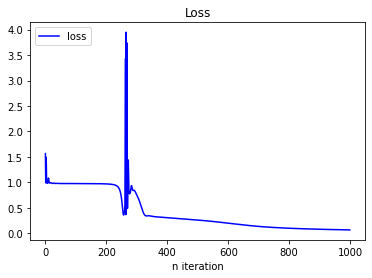

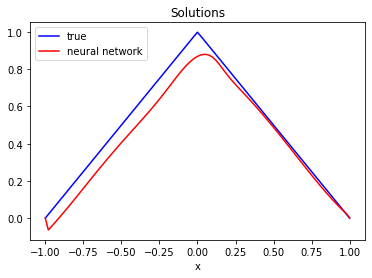

0.0053029078677652
Time = 44.26766324043274


In [9]:
time0 = time()
run_train(lr=0.01, num_e= 1000)
print(f"Time = {time() - time0}")

The running loss at 1 iteration is: 0.06845138364296938
The running loss at 51 iteration is: 0.1054906767312294
The running loss at 101 iteration is: 0.07036836535253368
The running loss at 151 iteration is: 0.06095896258121606
The running loss at 201 iteration is: 0.055608375667305955
The running loss at 251 iteration is: 0.050717266093913395
The running loss at 301 iteration is: 0.04571956550643236
The running loss at 351 iteration is: 0.040799340300360455
The running loss at 401 iteration is: 0.036216772049521305
The running loss at 451 iteration is: 0.03217264877481137
The running loss at 501 iteration is: 0.02875826137714392
The running loss at 551 iteration is: 0.025965513534671764
The running loss at 601 iteration is: 0.02372889345162785
The running loss at 651 iteration is: 0.02196180726203158
The running loss at 701 iteration is: 0.020575605754616474
The running loss at 751 iteration is: 0.019488384311475156
The running loss at 801 iteration is: 0.018629434010512515
The runnin

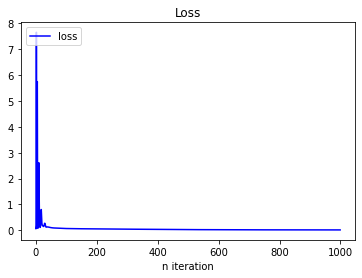

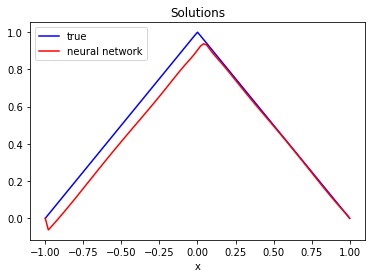

0.004148019780889731
Time = 44.26057577133179


In [10]:
time0 = time()
run_train(lr=0.01, num_e= 1000)
print(f"Time = {time() - time0}")

The running loss at 1 iteration is: 0.016507977887096306
The running loss at 51 iteration is: 0.08193855117847204
The running loss at 101 iteration is: 0.02469591871968456
The running loss at 151 iteration is: 0.019216392985204823
The running loss at 201 iteration is: 0.01761459918652612
The running loss at 251 iteration is: 0.01667452624924701
The running loss at 301 iteration is: 0.01595207463391168
The running loss at 351 iteration is: 0.015353324652116957
The running loss at 401 iteration is: 0.014844687391971645
The running loss at 451 iteration is: 0.01440341170710376
The running loss at 501 iteration is: 0.014012572992683013
The running loss at 551 iteration is: 0.013659399328086448
The running loss at 601 iteration is: 0.013333933730360818
The running loss at 651 iteration is: 0.01302769684334815
The running loss at 701 iteration is: 0.012734026092903753
The running loss at 751 iteration is: 0.012447944337085154
The running loss at 801 iteration is: 0.012166354364566801
The run

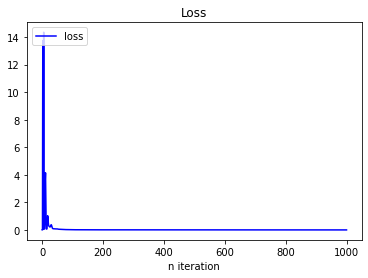

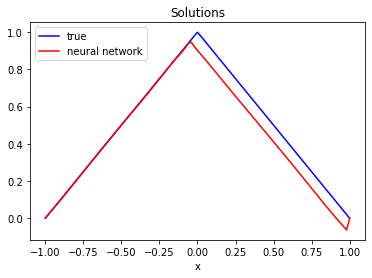

0.004158332886385424
Time = 44.309221506118774


In [11]:
time0 = time()
run_train(lr=0.01, num_e= 1000)
print(f"Time = {time() - time0}")

The running loss at 1 iteration is: 0.011060886801798309
The running loss at 51 iteration is: 0.01078877018692253
The running loss at 101 iteration is: 0.010554434976073444
The running loss at 151 iteration is: 0.010334129083486087
The running loss at 201 iteration is: 0.01011411829374546
The running loss at 251 iteration is: 0.009900331808585601
The running loss at 301 iteration is: 0.009697030251710665
The running loss at 351 iteration is: 0.00950650026207795
The running loss at 401 iteration is: 0.009329326577323214
The running loss at 451 iteration is: 0.009165127650540632
The running loss at 501 iteration is: 0.00901263539026222
The running loss at 551 iteration is: 0.008870358502145025
The running loss at 601 iteration is: 0.00873676885057912
The running loss at 651 iteration is: 0.00861039150573034
The running loss at 701 iteration is: 0.008490173005801831
The running loss at 751 iteration is: 0.008375309367815035
The running loss at 801 iteration is: 0.008265180464152295
The ru

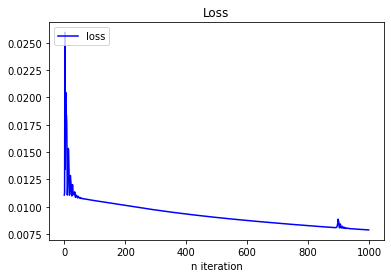

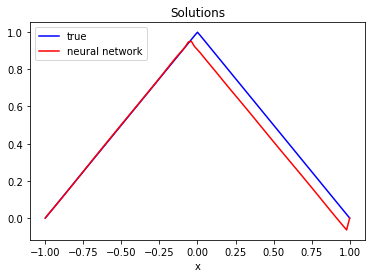

0.003976179432889155
Time = 44.20625567436218


In [12]:
time0 = time()
run_train(lr=0.001, num_e= 1000)
print(f"Time = {time() - time0}")

The running loss at 1 iteration is: 0.00787231160952559
The running loss at 51 iteration is: 0.021278771300867763
The running loss at 101 iteration is: 0.016809005669592078
The running loss at 151 iteration is: 0.016174331348243254
The running loss at 201 iteration is: 0.01575614396012838
The running loss at 251 iteration is: 0.015399187477128541
The running loss at 301 iteration is: 0.015083576134879829
The running loss at 351 iteration is: 0.01480472101042895
The running loss at 401 iteration is: 0.014557767800586166
The running loss at 451 iteration is: 0.014337416663850655
The running loss at 501 iteration is: 0.014138968054182436
The running loss at 551 iteration is: 0.01395869040989379
The running loss at 601 iteration is: 0.013793693745375816
The running loss at 651 iteration is: 0.013641544763758907
The running loss at 701 iteration is: 0.013500219331556042
The running loss at 751 iteration is: 0.01336795304732896
The running loss at 801 iteration is: 0.013243273015200879
The r

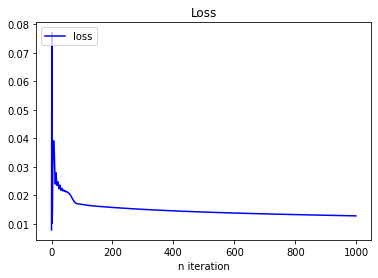

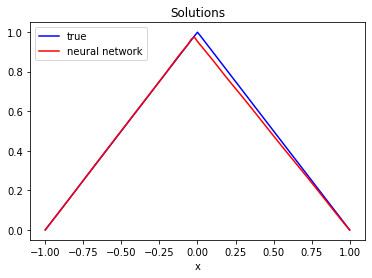

0.00038124807200514246
Time = 44.946404218673706


In [13]:
time0 = time()
run_train(lr=0.001, num_e= 1000)
print(f"Time = {time() - time0}")

The running loss at 1 iteration is: 0.012800602898433117
The running loss at 51 iteration is: 0.09038065395348067
The running loss at 101 iteration is: 0.029948907927878084
The running loss at 151 iteration is: 0.022235022874095026
The running loss at 201 iteration is: 0.017806304492819586
The running loss at 251 iteration is: 0.015415824535936833
The running loss at 301 iteration is: 0.014213779668936714
The running loss at 351 iteration is: 0.013619930413033379
The running loss at 401 iteration is: 0.013306658681339307
The running loss at 451 iteration is: 0.013112978670113589
The running loss at 501 iteration is: 0.012967597129358074
The running loss at 551 iteration is: 0.012841962414258973
The running loss at 601 iteration is: 0.012725634016480494
The running loss at 651 iteration is: 0.012615362473454328
The running loss at 701 iteration is: 0.012510076934841179
The running loss at 751 iteration is: 0.012409496663566572
The running loss at 801 iteration is: 0.012313504436738435
T

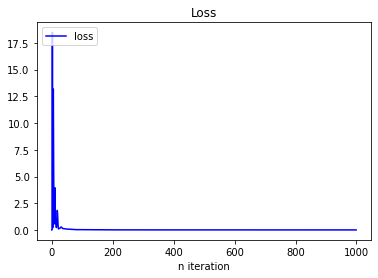

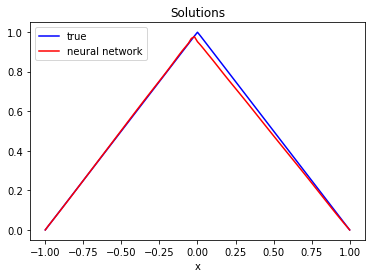

0.00038169205847427576
Time = 44.55771803855896


In [15]:
time0 = time()
run_train(lr=0.01, num_e= 1000)
print(f"Time = {time() - time0}")

The running loss at 1 iteration is: 0.011971608026621098
The running loss at 51 iteration is: 0.0118921915661741
The running loss at 101 iteration is: 0.011813167233970759
The running loss at 151 iteration is: 0.011738890594458672
The running loss at 201 iteration is: 0.011672690664187272
The running loss at 251 iteration is: 0.011613386743370637
The running loss at 301 iteration is: 0.011558705865956892
The running loss at 351 iteration is: 0.011506833524255298
The running loss at 401 iteration is: 0.011456434036082746
The running loss at 451 iteration is: 0.01140700263168691
The running loss at 501 iteration is: 0.011358209298794594
The running loss at 551 iteration is: 0.011310156038297778
The running loss at 601 iteration is: 0.011264045386191735
The running loss at 651 iteration is: 0.011219392465909124
The running loss at 701 iteration is: 0.011179113977582795
The running loss at 751 iteration is: 0.011134762937144022
The running loss at 801 iteration is: 0.011094346521963519
The

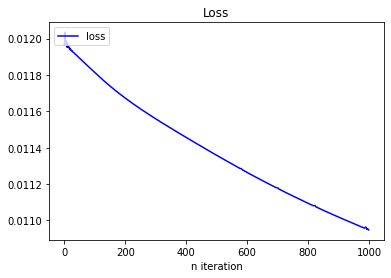

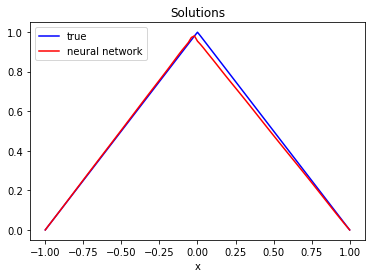

0.00033936299509530835
Time = 45.12696957588196


In [16]:
time0 = time()
run_train(lr=0.0001, num_e= 1000)
print(f"Time = {time() - time0}")

The running loss at 1 iteration is: 0.010949147413154448
The running loss at 51 iteration is: 0.010971783056682474
The running loss at 101 iteration is: 0.010910169866281988
The running loss at 151 iteration is: 0.010886496148293618
The running loss at 201 iteration is: 0.010861303506525824
The running loss at 251 iteration is: 0.010834805631571052
The running loss at 301 iteration is: 0.010807335144983096
The running loss at 351 iteration is: 0.01077906887562261
The running loss at 401 iteration is: 0.01075010415867186
The running loss at 451 iteration is: 0.010720672867877173
The running loss at 501 iteration is: 0.010690771812294346
The running loss at 551 iteration is: 0.010660524679596139
The running loss at 601 iteration is: 0.01063001032210034
The running loss at 651 iteration is: 0.010599265075400361
The running loss at 701 iteration is: 0.010568379859631053
The running loss at 751 iteration is: 0.01053734097812027
The running loss at 801 iteration is: 0.0105062218729377
The ru

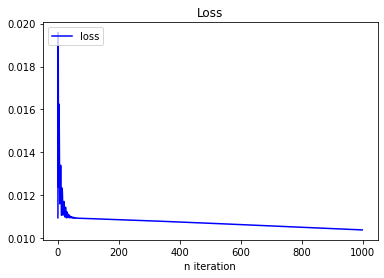

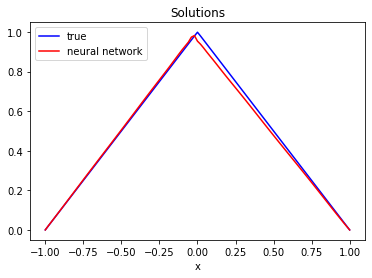

0.00033502809657228003
Time = 45.15610408782959


In [17]:
time0 = time()
run_train(lr=0.0005, num_e= 1000)
print(f"Time = {time() - time0}")

The running loss at 1 iteration is: 0.01038133164511337
The running loss at 51 iteration is: 0.010446723085391869
The running loss at 101 iteration is: 0.01034734223630628
The running loss at 151 iteration is: 0.010333297736508448
The running loss at 201 iteration is: 0.010318274761959824
The running loss at 251 iteration is: 0.010302157333264677
The running loss at 301 iteration is: 0.010285090204373274
The running loss at 351 iteration is: 0.010267163031377244
The running loss at 401 iteration is: 0.010248516967108635
The running loss at 451 iteration is: 0.01022915294231738
The running loss at 501 iteration is: 0.010209193302226555
The running loss at 551 iteration is: 0.01018855253015625
The running loss at 601 iteration is: 0.010167340045760346
The running loss at 651 iteration is: 0.010145511485681697
The running loss at 701 iteration is: 0.010123100639569168
The running loss at 751 iteration is: 0.010100120333911977
The running loss at 801 iteration is: 0.010076606925218395
The 

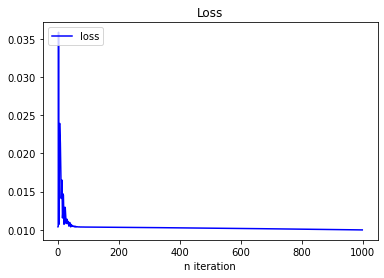

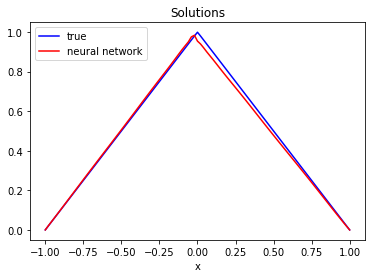

0.00032690821675914736
Time = 44.74847197532654


In [18]:
time0 = time()
run_train(lr=0.0009, num_e= 1000)
print(f"Time = {time() - time0}")

The running loss at 1 iteration is: 0.009976953504206056
The running loss at 51 iteration is: 0.024306688335000604
The running loss at 101 iteration is: 0.008838313592139633
The running loss at 151 iteration is: 0.00784625625232754
The running loss at 201 iteration is: 0.007539534153826582
The running loss at 251 iteration is: 0.007428402238714883
The running loss at 301 iteration is: 0.007368116425347518
The running loss at 351 iteration is: 0.007323875495134591
The running loss at 401 iteration is: 0.007287824882062035
The running loss at 451 iteration is: 0.0072576992492284316
The running loss at 501 iteration is: 0.007232187035917053
The running loss at 551 iteration is: 0.0072104238489908625
The running loss at 601 iteration is: 0.007191688145483836
The running loss at 651 iteration is: 0.007175278549132982
The running loss at 701 iteration is: 0.0071606702841887524
The running loss at 751 iteration is: 0.007147341890139209
The running loss at 801 iteration is: 0.00713492395278855

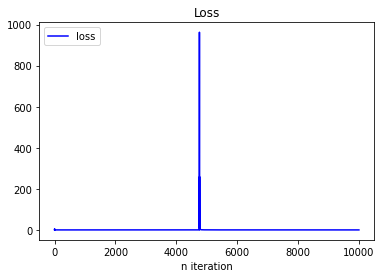

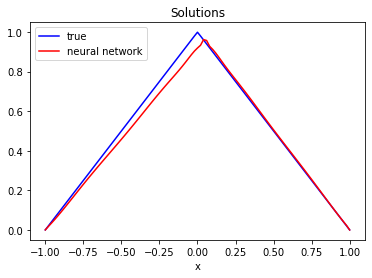

0.0011375409610123839
Time = 437.5939772129059


In [19]:
time0 = time()
run_train(lr=0.009, num_e= 10000)
print(f"Time = {time() - time0}")

The running loss at 1 iteration is: 0.02144187614609972
The running loss at 51 iteration is: 0.012091586611004426
The running loss at 101 iteration is: 0.009114448132162572
The running loss at 151 iteration is: 0.008665533905848613
The running loss at 201 iteration is: 0.008301119134421532
The running loss at 251 iteration is: 0.007961275320187325
The running loss at 301 iteration is: 0.00764317000307571
The running loss at 351 iteration is: 0.007350530786793138
The running loss at 401 iteration is: 0.007085880826000606
The running loss at 451 iteration is: 0.006851242967945373
The running loss at 501 iteration is: 0.006647426986607883
The running loss at 551 iteration is: 0.006474386494067375
The running loss at 601 iteration is: 0.006331480996304079
The running loss at 651 iteration is: 0.006216377549121628
The running loss at 701 iteration is: 0.006125672887134915
The running loss at 751 iteration is: 0.00606775363287509
The running loss at 801 iteration is: 0.006528196280167328
The

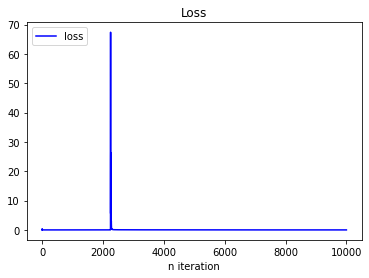

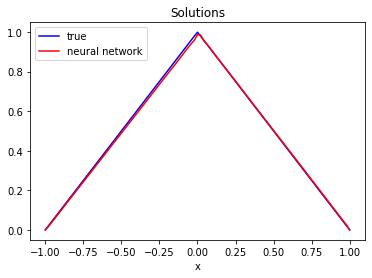

7.378043513121448e-05
Time = 432.70776104927063


In [20]:
time0 = time()
run_train(lr=0.01, num_e= 10000)
print(f"Time = {time() - time0}")

In [14]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
# save weights
filepath = '/content/drive/My Drive/Colab Notebooks/Project_PINNs/Eikonal01.txt'
torch.save(model.state_dict(), filepath)

In [ ]:
# #Later to restore:
model.load_state_dict(torch.load(filepath))
model.eval()

In [ ]:
def evaluate_np(x_data_np):
    u_hat = []
    for x in x_data_np:
        x_tensor = torch.tensor(np.array([x]), requires_grad= True)
        temp = model(x_tensor.float())
        u_hat.append(temp.clone().item())
        # u_hat = torch.hstack([u_hat, temp])
    return u_hat

In [ ]:
def evaluate_error_np(x_data_np):
    y_pred = evaluate_np(x_data_np)
    y_true = u_star_func(x_data_np)
    return np.mean(np.square(y_true -  y_pred))

In [ ]:
# Discritize the interval
a = 0
b = 1
step = (b-a)/100
x_init_np = np.arange(start=a, stop=b+step, step=step)

In [ ]:
x_init_np2 = np.arange(start=a, stop=b+step/10, step=step/10)
x_init2 = torch.tensor(x_init_np2, requires_grad= True)
# print(x_init)
# print(x_init2.shape)
y_pred2 = evaluate_np(x_init_np2)

draw_result(x_init_np2, y_pred2, 'solution-NN')
evaluate_error_np(x_init_np2)

In [ ]:
step_size = []
error = []
for k in [4,6,8,10,12, 14, 26]:
    x_vec = np.arange(start=a, stop=b+step/k, step=step/k)
    # x_vec_tensor = torch.tensor(x_vec, requires_grad= True)
    y_pred = evaluate_np(x_vec)
    error.append(evaluate_error_np(x_vec))
    step_size.append(step/k)

In [ ]:
draw_result(step_size[::-1], error[::-1], 'error')
print(step_size)

# Appendix: Understanding pytorch gradient

We create two vectors

$$a = \begin{bmatrix} {2\\3}
\end{bmatrix}, \qquad\text{and}\qquad b = \begin{bmatrix} {6\\4}
\end{bmatrix}$$

Let us consider the function

$$ Q(x,y) = 3x^3 - y^2$$

The convention here is that, if 
$$\mathbf{x} = \begin{bmatrix} {x_1\\x_2\\ \vdots\\ x_n}
\end{bmatrix} \qquad\text{and}\qquad \mathbf{y} = \begin{bmatrix} {y_1\\y_2\\ \vdots\\ y_n}
\end{bmatrix}$$
then
the action of $Q$ on $\mathbf{x}, \mathbf{y}$ are component-wise, i.e.,

$$ Q(\mathbf{x},\mathbf{y}) = \begin{bmatrix} {Q(x_1,y_1)\\ Q(x_2,y_2)\\ \vdots\\ Q(x_n,y_n)}
\end{bmatrix} $$

In `pytorch`, this is saved as a tensor object.